# Emerging Technologies Project

The following notebook trains a model that can be used to predict power output from wind speed values, as defined in the `powerproduction` dataset.

## Preamble

I'll begin by importing the necessary packages and reading in the dataset.

In [1]:
import tensorflow.keras as kr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Plot style
plt.style.use("ggplot")

# Plot size
plt.rcParams["figure.figsize"] = [14, 8]

In [3]:
# Read in the dataset
df = pd.read_csv("./powerproduction.csv")

# Print the first few rows
df.head(8)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826


Next I'll partition the dataset it into two subsets. The first will be used to fit the model and is referred to as the training dataset, while the second will instead be used to make predictions based on the training data. The objective of splitting the data is to provide a way to estimate the performance of the machine learning model when it is presented with new data, i.e. data that wasn't used to train the model [1].

The training set will make up 80% of the total items in the overall dataset.

In [4]:
# Create train and test sets
# Reference: TensorFlow documentation
# https://www.tensorflow.org/tutorials/keras/regression#split_the_data_into_train_and_test
train = df.sample(frac=0.8, random_state=0)
test = df.drop(train.index)

print("Training:")
print(train.head())
print("\nTesting:")
print(test.head())

Training:
      speed    power
90    4.905    7.060
254  12.713   51.149
283  14.489   71.763
445  22.422   99.357
461  23.273  113.556

Testing:
    speed  power
9   0.526  5.553
25  1.051  2.085
28  1.151  1.208
31  1.301  0.000
32  1.401  4.156


In order to better visualise the training and testing data sets we can plot them both using Matplotlib.

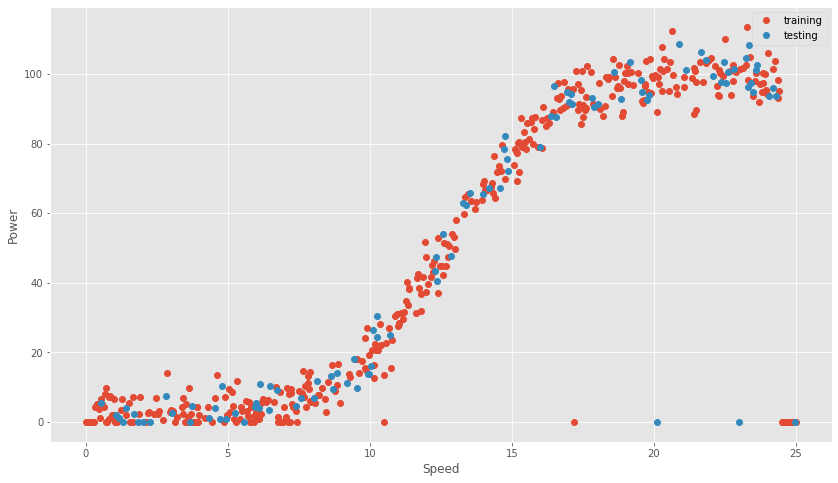

In [5]:
plt.plot(
    train.speed,
    train.power,
    "o",
    label="training"
)

plt.plot(
    test.speed, 
    test.power,
    "o",
    label="testing"
)

plt.xlabel("Speed")
plt.ylabel("Power")

plt.legend();

## Creating a Linear Model

Now I'll construct a linear modal and attempt to use it in order to make predictions. This is done below using Keras' `Sequential` class, which represents a linear grouping of layers [2]. The model created below contains a single dense layer. A dense layer is a layer in neural network that’s fully connected, meaning all the neurons in one layer are connected to all other neurons in the next layer [2].

In [6]:
# Create a neural network with one neuron
model = kr.models.Sequential()

# Add a single dense layer
model.add(
    kr.layers.Dense(
        1,
        input_shape=(1,),
        activation="linear",
        kernel_initializer="ones",
        bias_initializer="zeros"
    )
)

# Compile the model
model.compile("adam", loss="mean_squared_error")

In [7]:
# Train the neural network on the training data
model.fit(
    train.speed,
    train.power,
    epochs=200,
    batch_size=10
)

Epoch 1/200
40/40 [==============================] - 0s 401us/step - loss: 2566.4383
Epoch 2/200
40/40 [==============================] - 0s 801us/step - loss: 2391.9813
Epoch 3/200
40/40 [==============================] - 0s 167us/step - loss: 2274.3830
Epoch 4/200
40/40 [==============================] - 0s 401us/step - loss: 2481.4224
Epoch 5/200
40/40 [==============================] - 0s 635us/step - loss: 2292.9412
Epoch 6/200
40/40 [==============================] - 0s 453us/step - loss: 2110.3568
Epoch 7/200
40/40 [==============================] - 0s 401us/step - loss: 2193.9121
Epoch 8/200
40/40 [==============================] - 0s 662us/step - loss: 2043.8769
Epoch 9/200
40/40 [==============================] - 0s 180us/step - loss: 2111.0230
Epoch 10/200
40/40 [==============================] - 0s 801us/step - loss: 2121.7857
Epoch 11/200
40/40 [==============================] - 0s 401us/step - loss: 2045.2712
Epoch 12/200
40/40 [==============================] - 0s 401us/

40/40 [==============================] - 0s 801us/step - loss: 556.3661
Epoch 98/200
40/40 [==============================] - 0s 969us/step - loss: 548.7801
Epoch 99/200
40/40 [==============================] - 0s 802us/step - loss: 568.0545
Epoch 100/200
40/40 [==============================] - 0s 801us/step - loss: 577.1841
Epoch 101/200
40/40 [==============================] - 0s 970us/step - loss: 484.0005
Epoch 102/200
40/40 [==============================] - 0s 800us/step - loss: 488.8317
Epoch 103/200
40/40 [==============================] - 0s 1ms/step - loss: 569.1068
Epoch 104/200
40/40 [==============================] - 0s 802us/step - loss: 584.4903
Epoch 105/200
40/40 [==============================] - 0s 1ms/step - loss: 634.7885
Epoch 106/200
40/40 [==============================] - 0s 970us/step - loss: 516.3742
Epoch 107/200
40/40 [==============================] - 0s 801us/step - loss: 629.9771
Epoch 108/200
40/40 [==============================] - 0s 836us/step - los

40/40 [==============================] - 0s 401us/step - loss: 546.3726
Epoch 193/200
40/40 [==============================] - 0s 736us/step - loss: 572.0135
Epoch 194/200
40/40 [==============================] - 0s 231us/step - loss: 520.2092
Epoch 195/200
40/40 [==============================] - 0s 802us/step - loss: 573.2139
Epoch 196/200
40/40 [==============================] - 0s 401us/step - loss: 593.2079
Epoch 197/200
40/40 [==============================] - 0s 401us/step - loss: 518.1099
Epoch 198/200
40/40 [==============================] - 0s 401us/step - loss: 532.1655
Epoch 199/200
40/40 [==============================] - 0s 568us/step - loss: 490.0420
Epoch 200/200
40/40 [==============================] - 0s 401us/step - loss: 504.8516


### Analysis

Now that the training process is complete, the model can be used to make predictions. First I'll visualise the results by plotting the values from the `train` dataset alongside the predicted values of each point in the `test` dataset. I'll create a function for this since I'm going to be reusing a lot of the below code throughout the notebook.

In [8]:
def plot_predictions(pred_speed=None, pred_power=None):
    """
    Creates a plot of the training dataset alongside the predicted values of each point
    in the test dataset.
    
    :param float pred_speed: Can be used to plot a specific predicted speed value.
    :param float pred_power: Can be used to plot a specific predicted power value.
    """
    # Plot the training dataset
    plt.plot(
        train.speed,
        train.power,
        "o",
        label="actual"
    )

    # Plot the predictions from the `test` dataset
    plt.plot(
        test.speed, 
        model.predict(test.speed),
        label="predictions"
    )
    
    if pred_speed is not None and pred_power is not None:
        # Show the prediction location on the plot
        # Ref: https://www.mathworks.com/matlabcentral/answers/430336-draw-lines-from-both-axis-to-point-in-plot
        plt.plot(pred_speed, pred_power, "ko")
        plt.plot([pred_speed, pred_speed], [0, pred_power], "k-")
        plt.plot([0, pred_speed], [pred_power, pred_power], "k-")

    plt.xlabel("Speed")
    plt.ylabel("Power")

    plt.legend();

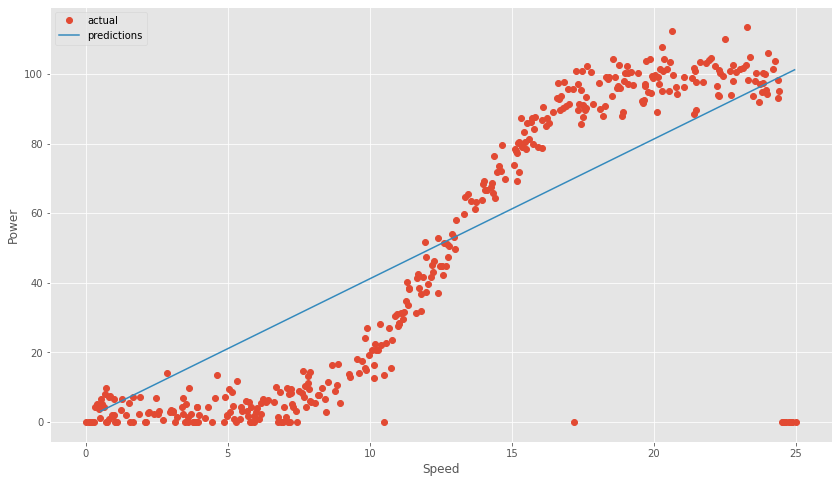

In [9]:
plot_predictions()

We can also predict individual values using Keras' `model.predict()` function. Below I find the predicted power output if the speed is 20, and then show where the result appears on the plot.

In [10]:
# Take a hand-picked speed value and view its predicted power
pred_speed = 20.0
pred_power = model.predict([pred_speed])[0]

pred_power

array([81.30376], dtype=float32)

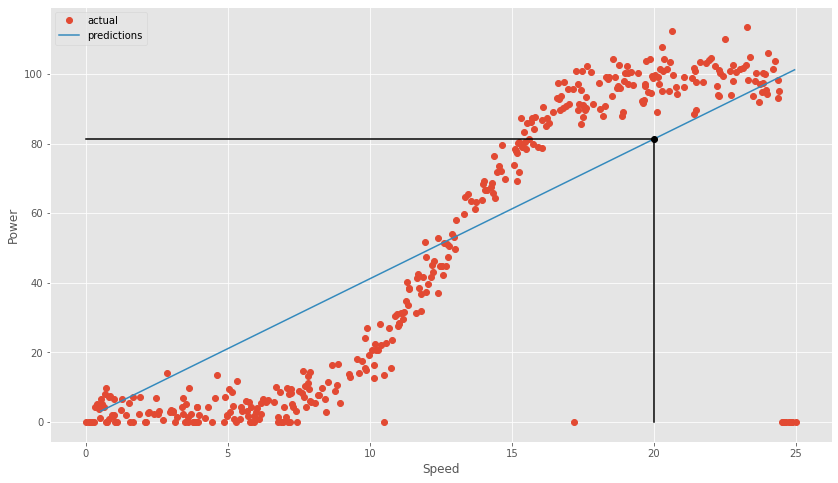

In [11]:
plot_predictions(pred_speed, pred_power)

As illustrated above, if we attempt to predict the power when the wind speed is 20, we get a value that is much lower than what we would expect. This is because the data in our dataset is not linear, and therefore linear regression is not the best form of regression to perform if we want to make accurate predictions.

## Non-Linear Regression

Linear regression assumes that the relationship between an independent variable $x$ and a dependent variable $y$ can be best expressed with a line [3]. However, because the `powerproduction` dataset is non-linear, it would make more sense to do polynomial regression. Polynomial regression expresses the relationship between two variables as a polynomial curve [3].

Below I'll rebuild the model, this time using the *sigmoid* activation function. An activation function is simply a mathematical function that takes in an input and produces an output [4]. The function is activated when the computed result reaches a specified threshold and the output is then passed onto the neurons on the subsequent layer [4]. The sigmoid activation function is "S" shaped and can add non-linearity to the output [4].

In [12]:
# Re-build the model
model = kr.models.Sequential()

model.add(
    kr.layers.Dense(
        64,
        input_shape=(1,),
        activation="sigmoid",
        kernel_initializer="glorot_uniform",
        bias_initializer="glorot_uniform"
    )
)

model.add(kr.layers.Dense(1, activation="linear"))

model.compile(kr.optimizers.Adam(lr=0.001), loss="mean_squared_error")

In [13]:
# Fit the data
model.fit(
    train.speed,
    train.power,
    epochs=300,
    batch_size=10
)

Epoch 1/300
40/40 [==============================] - 0s 804us/step - loss: 3801.4177
Epoch 2/300
40/40 [==============================] - 0s 801us/step - loss: 3741.5255
Epoch 3/300
40/40 [==============================] - 0s 401us/step - loss: 3280.0243
Epoch 4/300
40/40 [==============================] - 0s 555us/step - loss: 3547.5991
Epoch 5/300
40/40 [==============================] - 0s 802us/step - loss: 2812.6274
Epoch 6/300
40/40 [==============================] - 0s 401us/step - loss: 3079.5134
Epoch 7/300
40/40 [==============================] - 0s 801us/step - loss: 2753.0956
Epoch 8/300
40/40 [==============================] - 0s 568us/step - loss: 2624.4961
Epoch 9/300
40/40 [==============================] - 0s 401us/step - loss: 2724.8875
Epoch 10/300
40/40 [==============================] - 0s 401us/step - loss: 2252.5328
Epoch 11/300
40/40 [==============================] - 0s 401us/step - loss: 2325.6391
Epoch 12/300
40/40 [==============================] - 0s 401us/

40/40 [==============================] - 0s 167us/step - loss: 349.9295
Epoch 97/300
40/40 [==============================] - 0s 802us/step - loss: 425.0355
Epoch 98/300
40/40 [==============================] - 0s 401us/step - loss: 408.6928
Epoch 99/300
40/40 [==============================] - 0s 401us/step - loss: 325.4450
Epoch 100/300
40/40 [==============================] - 0s 801us/step - loss: 316.6713
Epoch 101/300
40/40 [==============================] - 0s 167us/step - loss: 289.1170
Epoch 102/300
40/40 [==============================] - 0s 401us/step - loss: 292.4992
Epoch 103/300
40/40 [==============================] - 0s 401us/step - loss: 305.5029
Epoch 104/300
40/40 [==============================] - 0s 401us/step - loss: 339.8994
Epoch 105/300
40/40 [==============================] - 0s 401us/step - loss: 303.6833
Epoch 106/300
40/40 [==============================] - 0s 401us/step - loss: 283.3136
Epoch 107/300
40/40 [==============================] - 0s 401us/step - 

40/40 [==============================] - 0s 486us/step - loss: 189.6888
Epoch 192/300
40/40 [==============================] - 0s 802us/step - loss: 192.0679
Epoch 193/300
40/40 [==============================] - 0s 401us/step - loss: 338.0199
Epoch 194/300
40/40 [==============================] - 0s 801us/step - loss: 270.3443
Epoch 195/300
40/40 [==============================] - 0s 568us/step - loss: 251.4528
Epoch 196/300
40/40 [==============================] - 0s 802us/step - loss: 217.6940
Epoch 197/300
40/40 [==============================] - 0s 801us/step - loss: 308.7952
Epoch 198/300
40/40 [==============================] - 0s 401us/step - loss: 273.4749
Epoch 199/300
40/40 [==============================] - 0s 568us/step - loss: 232.8341
Epoch 200/300
40/40 [==============================] - 0s 1ms/step - loss: 279.3502
Epoch 201/300
40/40 [==============================] - 0s 801us/step - loss: 154.6337
Epoch 202/300
40/40 [==============================] - 0s 802us/step -

40/40 [==============================] - 0s 802us/step - loss: 292.0813
Epoch 287/300
40/40 [==============================] - 0s 594us/step - loss: 227.0059
Epoch 288/300
40/40 [==============================] - 0s 401us/step - loss: 184.0978
Epoch 289/300
40/40 [==============================] - 0s 400us/step - loss: 239.1148
Epoch 290/300
40/40 [==============================] - 0s 801us/step - loss: 295.3903
Epoch 291/300
40/40 [==============================] - 0s 569us/step - loss: 202.4383
Epoch 292/300
40/40 [==============================] - 0s 801us/step - loss: 235.2017
Epoch 293/300
40/40 [==============================] - 0s 401us/step - loss: 246.5620
Epoch 294/300
40/40 [==============================] - 0s 968us/step - loss: 373.4527
Epoch 295/300
40/40 [==============================] - 0s 802us/step - loss: 344.9567
Epoch 296/300
40/40 [==============================] - 0s 401us/step - loss: 300.3030
Epoch 297/300
40/40 [==============================] - 0s 801us/step

### Analysis

Once again, we can use this newly created model to make predictions. As done previously, I'll plot the values of the `train` dataset along with the predicted values of each point in the `test` dataset. Doing so, we'll find the predicted values appear to form a curved line.

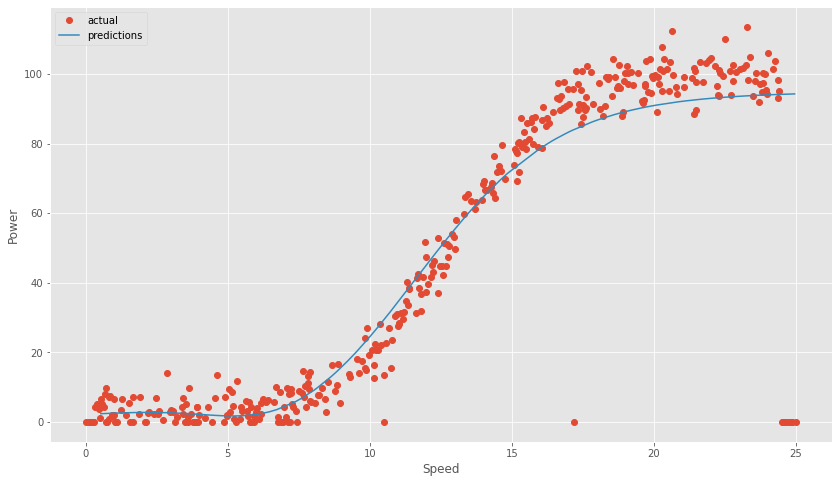

In [14]:
plot_predictions()

Again, we can provide an input speed of 20 to Keras' `model.predict()` function and plot the result.

In [15]:
pred_power = model.predict([pred_speed])[0]

pred_power

array([90.91004], dtype=float32)

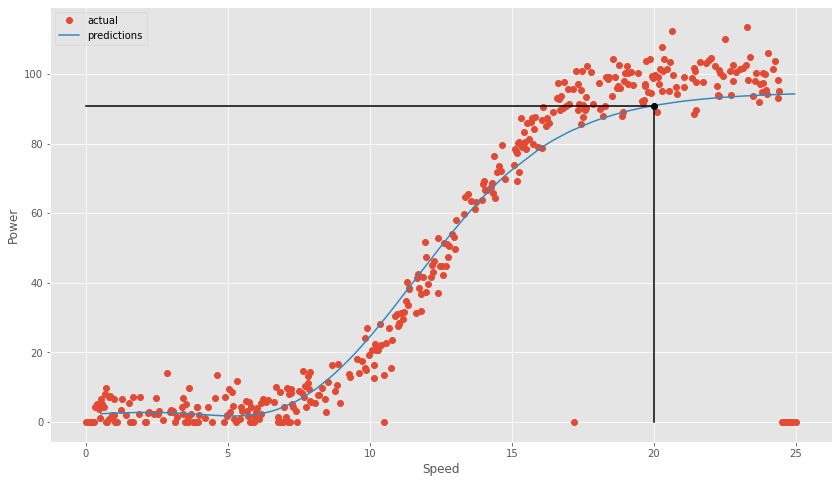

In [16]:
plot_predictions(pred_speed, pred_power)

We see that the result when using non-linear regression is much more accurate compared to the linear model tested previously.

## Saving the Model

We can use `model.save()` to easily save the model for later use in the web application.

In [17]:
model.save("power_prod.h5")

## References

1. [Train-Test Split for Evaluating Machine Learning Algorithms](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/). Jason Brownlee. Machine Learning Mastery.
2. [Linear Regression using Keras and Python](https://heartbeat.fritz.ai/linear-regression-using-keras-and-python-7cee2819a60c). Dhiraj K. Heartbeat.
3. [Polynomial Regression using tf.keras](https://medium.com/@anigasan637/polynomial-regression-using-tf-keras-17eaac771256). Ananya Gangavarapu. Medium.
4. [Neural Network Activation Function Types](https://medium.com/fintechexplained/neural-network-activation-function-types-a85963035196). Farhad Malik. Medium.